# Plot the following from the steric height

 - Raw time-series at each mooring (down to 60 s)
 - PSD of time-series
 - Band-pass time-series at each mooring (sub-tidal, tidal, super-tidal)
 - Spatial gradient of each band-pass component
 - Calculate linear plane fit at each time step and remove --> Plot the de-planed signals (time-series and PSD)

In [20]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from s3fs import S3FileSystem, S3Map

import cmocean as cm

In [53]:
plt.rcParams['font.size']=14
plt.rcParams['axes.labelsize']='medium'
plt.rcParams['pcolor.shading']='auto'

In [54]:
ds = [xr.open_dataset('../DATA/mooring_steric_ssh_W310_v2.nc'),
      xr.open_dataset('../DATA/mooring_steric_ssh_S245_v2.nc')]

# N280 needs to be interpolated onto the same time step
ds.append(xr.open_dataset('../DATA/mooring_steric_ssh_N280_v2.nc').interp_like(ds[0]))

colors = ['orange', 'navy', 'r']
sites = ['W310','S245','N280']

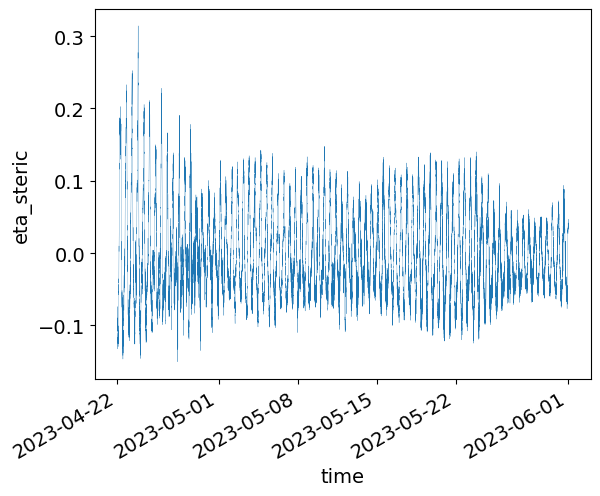

In [55]:
(ds[2]['eta_steric']-ds[1]['eta_steric']).plot(lw=0.2)

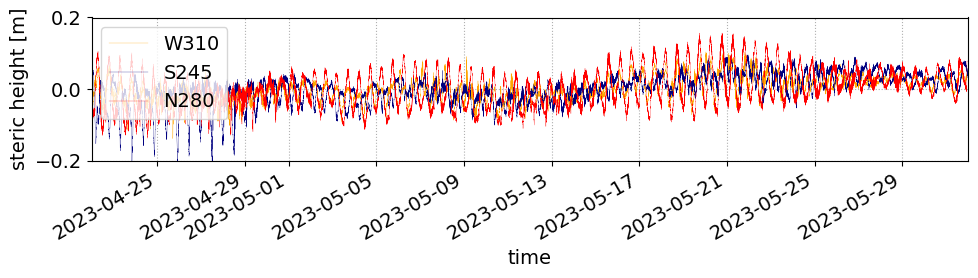

In [56]:

plt.figure(figsize=(10,3))
ax=plt.subplot(111)
for d,c in zip(ds, colors):
    d['eta_steric'].plot(c=c, lw=0.2)
plt.legend(sites)
ax.set_xlim(ds[0].time[0],ds[0].time[-1])
ax.set_ylim(-0.2, 0.2)
plt.title('')
plt.grid(True, ls=':')
plt.tight_layout()
plt.savefig('../FIGURES/raw_eta_steric_3sites.png', dpi=150)

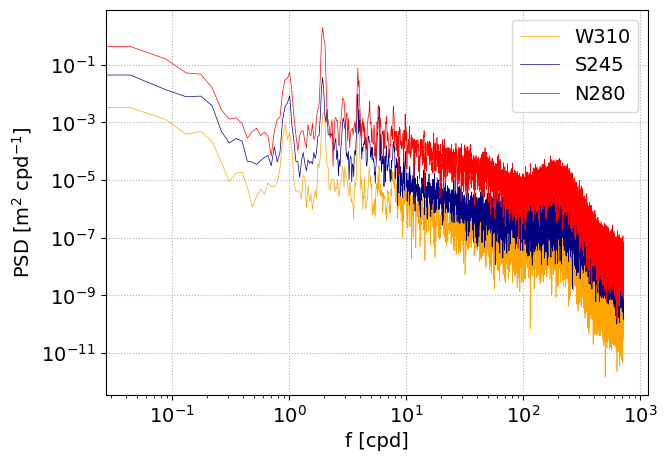

In [57]:
# Plot the PSD of each mooring
from scipy import signal

plt.figure(figsize=(7,5))
ax=plt.subplot(111)
scale = 1
for d,c in zip(ds, colors):
    f, P = signal.welch(d['eta_steric'], fs=86400/60., nperseg=4*8192)
    plt.loglog(f, P*scale, c=c, lw=0.5)
    scale*=10

plt.xlabel('f [cpd]')
plt.ylabel('PSD [m$^2$ cpd$^{-1}$]')
plt.grid(True, ls=':')
plt.legend(sites)
plt.savefig('../FIGURES/psd_eta_steric_3sites.png', dpi=150)

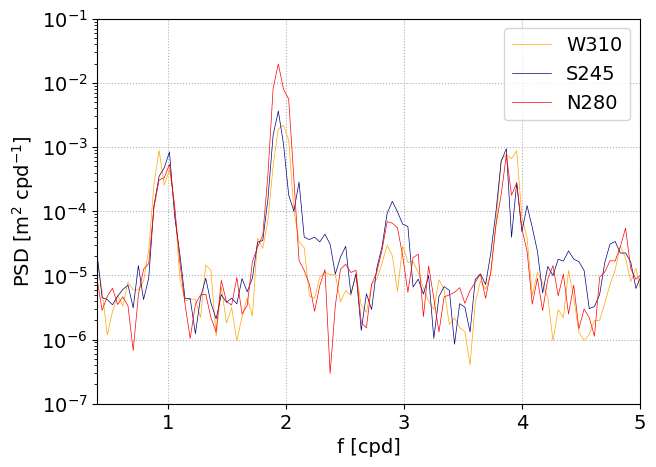

In [58]:
plt.figure(figsize=(7,5))
ax=plt.subplot(111)
scale = 1
for d,c in zip(ds, colors):
    f, P = signal.welch(d['eta_steric'], fs=86400/60., nperseg=4*8192)
    plt.semilogy(f, P*scale, c=c, lw=0.5)
    scale*=1

plt.xlim(0.4, 5)
plt.xlabel('f [cpd]')
plt.ylabel('PSD [m$^2$ cpd$^{-1}$]')
plt.grid(True, ls=':')
plt.legend(sites)
ax.set_ylim(1e-7,1e-1)

plt.savefig('../FIGURES/psd_eta_steric_3sites_zoom.png', dpi=150)

# Band pass and plot the 3 moorings

In [59]:
from utils import filt_decompose

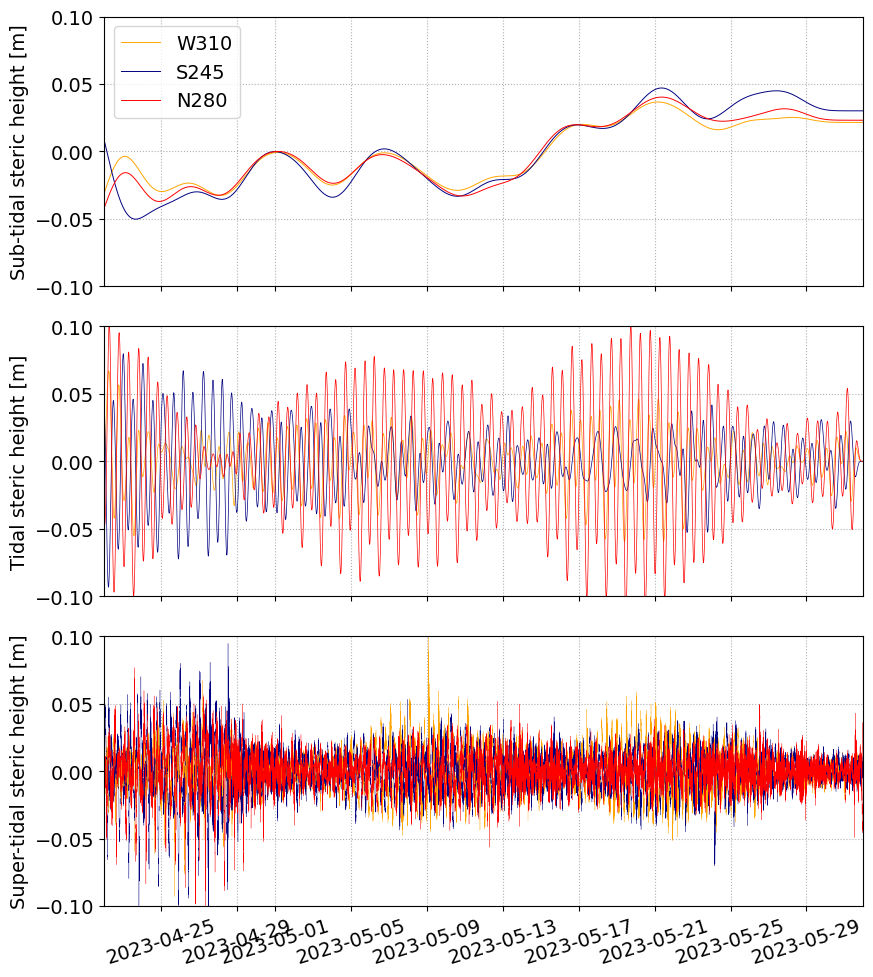

In [60]:
plt.figure(figsize=(9,10))

time = ds[0].time

ax1 = plt.subplot(311)
ax1.set_xticklabels([])
ax1.set_ylim(-0.1, 0.1)
ax1.set_xlim(time[0],time[-1])
ax1.set_ylabel('Sub-tidal steric height [m]')
plt.grid(True, ls=':')


ax2 = plt.subplot(312)
ax2.set_xticklabels([])
ax2.set_ylim(-0.1, 0.1)
ax2.set_xlim(time[0],time[-1])
ax2.set_ylabel('Tidal steric height [m]')
plt.grid(True, ls=':')

ax3 = plt.subplot(313)
# ax3.set_xticklabels([])
ax3.set_ylim(-0.1,0.1)
plt.xticks(rotation=17)
ax3.set_xlim(time[0],time[-1])
ax3.set_ylabel('Super-tidal steric height [m]')
plt.grid(True, ls=':')


for d,c in zip(ds, colors):
    dt = 60.
    yf = filt_decompose(d['eta_steric'], dt)
    time = d.time
    
    ax1.plot(time, yf[:,0], lw=0.7, c=c)
    ax2.plot(time, yf[:,1], lw=0.5, c=c)
    ax3.plot(time, yf[:,2], lw=0.2, c=c)

ax1.legend(sites)
plt.tight_layout()
plt.savefig('../FIGURES/eta_steric_filtered_3sites.png', dpi=150)

# Plot the sub-25 km variability



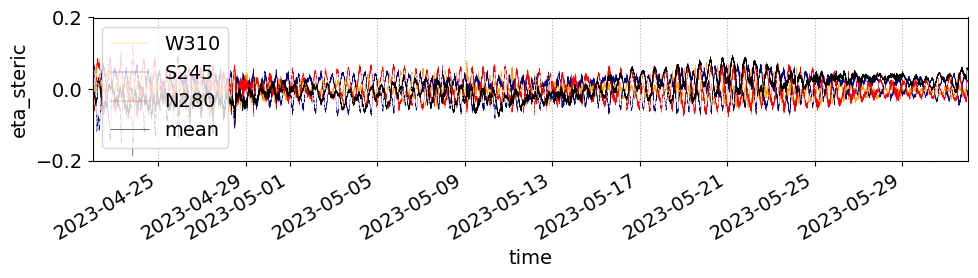

In [61]:
ssh_mean = (ds[0]['eta_steric']+ds[1]['eta_steric']+ds[2]['eta_steric'])/3.


plt.figure(figsize=(10,3))
ax=plt.subplot(111)
for d,c in zip(ds, colors):
    (d['eta_steric']-ssh_mean).plot(c=c, lw=0.2)

ssh_mean.plot(c='k',lw=0.4)
plt.legend(sites+['mean',])
ax.set_xlim(ds[0].time[0],ds[0].time[-1])
ax.set_ylim(-0.2, 0.2)
plt.title('')
plt.grid(True, ls=':')
plt.tight_layout()
plt.savefig('../FIGURES/eta_steric_minus_spatialmean_3sites.png', dpi=150)

# Compute plane fit

In [62]:
## Testing
m_x = -0.01
m_y = -0.02
m_c = 0.04

x = np.array([[1,2,3],[3,2,1]])
y = np.array([[-1,2,3],[3,-1, 2]])

def plane_func(x, y, params):
    m_x, m_y, m_c = params
    return m_x*x + m_y*y + m_c
    
z_test = plane_func(x, y, (m_x, m_y, m_c))

N = 3 # Number of data points in space
A = np.array([ x[0,:], y[0,:], np.ones(N,)]).T
z_test[0,:]

soln = np.linalg.solve(A, z_test[0,:])
# soln = np.linalg.solve(A, z_test)

print(soln)
print(m_x, m_y, m_c)
A

[-0.01 -0.02  0.04]
-0.01 -0.02 0.04


array([[ 1., -1.,  1.],
       [ 2.,  2.,  1.],
       [ 3.,  3.,  1.]])

In [63]:
# Project the coordinates
from sfoda.utils.myproj import MyProj

In [64]:
P = MyProj(None, utmzone=51, isnorth=False)

X = []
Y = []
for d in ds:
    x,y = P.to_xy(d.lon_nom.values, d.lat_nom.values)
    X.append(x)
    Y.append(y)
X, Y

([482415.5295098219, 503281.7767103765, 503162.3328247733],
 [8437094.967728006, 8426764.490723545, 8446484.940355701])

In [65]:
N = 3 # Number of data points in space
A = np.array([ X, Y, 1e3*np.ones(N,)]).T
A = A/1e3

nt = ds[0]['time'].shape[0]
eta_x = np.zeros((nt,))
eta_y = np.zeros((nt,))
eta_offset = np.zeros((nt,))
eta = np.vstack([ds[0]['eta_steric'].values,
                 ds[1]['eta_steric'].values,
                 ds[2]['eta_steric'].values,
                ])*100 # units cm
print(A)
for ii in range(nt):
    soln = np.linalg.solve(A, eta[:,ii])
    eta_x[ii] = soln[0]
    eta_y[ii] = soln[1]
    eta_offset[ii] = soln[2]

[[4.82415530e+02 8.43709497e+03 1.00000000e+00]
 [5.03281777e+02 8.42676449e+03 1.00000000e+00]
 [5.03162333e+02 8.44648494e+03 1.00000000e+00]]


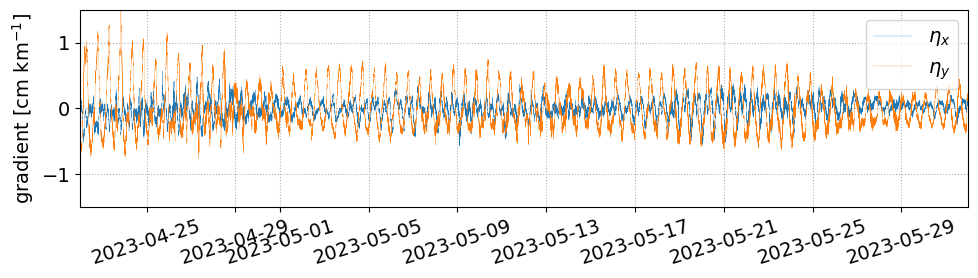

In [66]:
plt.figure(figsize=(10,3))
ax=plt.subplot(111)

plt.plot(time, eta_x, lw=0.2)
plt.plot(time, eta_y, lw=0.2)
plt.legend(('$\eta_x$','$\eta_y$'))
ax.set_xlim(ds[0].time[0],ds[0].time[-1])
ax.set_ylim(-1.5, 1.5)
plt.title('')
plt.xticks(rotation=17)
plt.grid(True, ls=':')
plt.ylabel('gradient [cm km$^{-1}$]')
plt.tight_layout()
plt.savefig('../FIGURES/eta_steric_gradient_3sites.png', dpi=150)

In [67]:

eta_x_f = filt_decompose(eta_x, dt)
eta_y_f = filt_decompose(eta_y, dt)

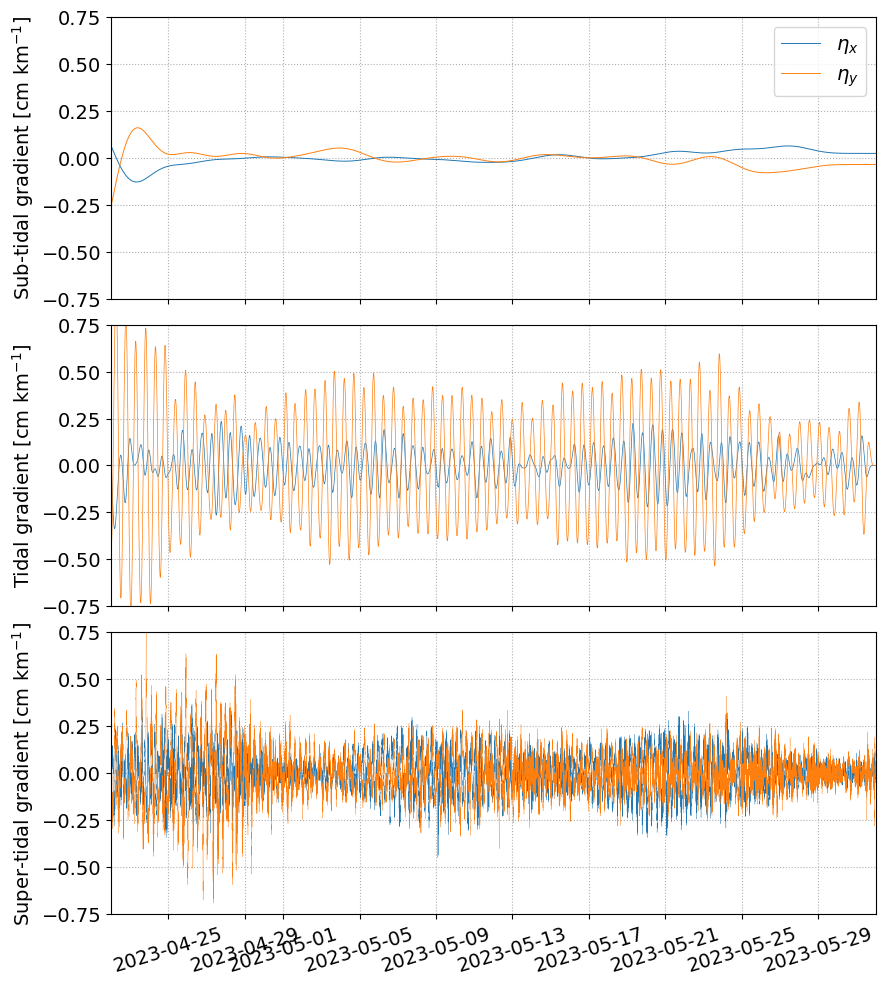

In [68]:
ylim = (-0.75, 0.75)
plt.figure(figsize=(9,10))

ax1 = plt.subplot(311)
ax1.set_xticklabels([])
ax1.set_ylim(ylim)
ax1.set_xlim(time[0],time[-1])
ax1.set_ylabel('Sub-tidal gradient [cm km$^{-1}$]')
plt.grid(True, ls=':')


ax2 = plt.subplot(312)
ax2.set_xticklabels([])
ax2.set_ylim(ylim)
ax2.set_xlim(time[0],time[-1])
ax2.set_ylabel('Tidal gradient [cm km$^{-1}$]')
plt.grid(True, ls=':')

ax3 = plt.subplot(313)
# ax3.set_xticklabels([])
ax3.set_ylim(ylim)
plt.xticks(rotation=17)
ax3.set_xlim(time[0],time[-1])
ax3.set_ylabel('Super-tidal gradient [cm km$^{-1}$]')
plt.grid(True, ls=':')

ax1.plot(time, eta_x_f[:,0], lw=0.7, )
ax1.plot(time, eta_y_f[:,0], lw=0.7, )

ax2.plot(time, eta_x_f[:,1], lw=0.5, )
ax2.plot(time, eta_y_f[:,1], lw=0.5, )

ax3.plot(time, eta_x_f[:,2], lw=0.2, )
ax3.plot(time, eta_y_f[:,2], lw=0.2, )

ax1.legend(('$\eta_x$','$\eta_y$'))

plt.tight_layout()
plt.savefig('../FIGURES/eta_steric_gradient_filtered_3sites.png', dpi=150)

In [52]:
# Calculate geostrophic velocity (not strictly geostrophic because this is not SSH)
f_cor = 2*2*np.pi/86400.*np.sin(ds[0].lat_nom.values*np.pi/180.)
u_gos = -9.81/f_cor * eta_y_f[:,0]/1e5 # m/m
v_gos = 9.81/f_cor * eta_x_f[:,0]/1e5 # m/m

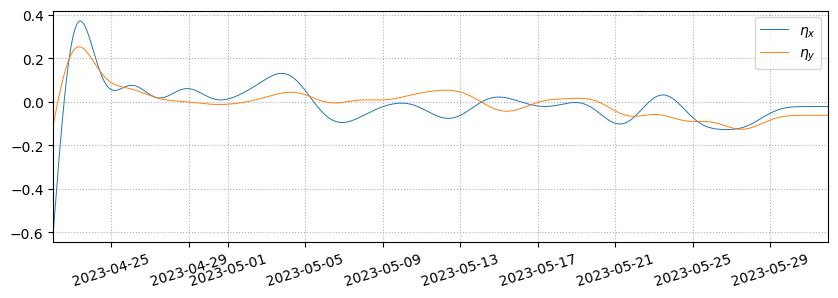

In [19]:
plt.figure(figsize=(10,3))
ax=plt.subplot(111)

plt.plot(time, u_gos, lw=0.7)
plt.plot(time, v_gos, lw=0.7)
plt.legend(('$\eta_x$','$\eta_y$'))
ax.set_xlim(ds[0].time[0],ds[0].time[-1])
# ax.set_ylim(-1.5, 1.5)
plt.title('')
plt.xticks(rotation=17)
plt.grid(True, ls=':')
# plt.ylabel('velocity [cm km$^{-1}$]')